In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", font_scale=1.5)
sns.set_palette("colorblind")
sns.despine()

<Figure size 640x480 with 0 Axes>

In [30]:
results_path = "../logs/mbrl_results/results_mujoco_halfcheetah_expert-v0/results_20250827_102123.parquet"
results_df = pd.read_parquet(results_path)

In [31]:
results_df.head()

,epoch,mean_error,loss,grad_norm,hidden_sizes,fixed_logstd,learning_rate,n_updates,loss_type,input_dim,...,sigma_error,entropy,reward_mean,n_generations,use_rsample,reward_transform,entropy_weight,reward_fn,U,clip_coef
0,0,8.072351,65.162842,21.349932,"[64, 64]",False,0.001,200,MSE,23,...,NaN,NaN,NaN,NaN,None,None,NaN,None,None,None
1,1,8.023772,64.380920,21.293270,"[64, 64]",False,0.001,200,MSE,23,...,NaN,NaN,NaN,NaN,None,None,NaN,None,None,None
2,2,7.975386,63.606781,21.343716,"[64, 64]",False,0.001,200,MSE,23,...,NaN,NaN,NaN,NaN,None,None,NaN,None,None,None
3,3,7.927004,62.837395,21.513048,"[64, 64]",False,0.001,200,MSE,23,...,NaN,NaN,NaN,NaN,None,None,NaN,None,None,None
4,4,7.878352,62.068424,21.840597,"[64, 64]",False,0.001,200,MSE,23,...,NaN,NaN,NaN,NaN,None,None,NaN,None,None,None


In [32]:
# Filter test data and calculate statistics
test_data = results_df[results_df["train_val"] == "test"].copy()

# Separate MSE and NLL baseline results
baseline_stats = (
    test_data[test_data["loss_type"].isin(["MSE", "NLL"])]
    .groupby("loss_type")
    .agg({"mean_error": ["mean", "std", "count"], "NLL": ["mean", "std", "count"]})
    .round(4)
)

# PG results grouped by U
pg_data = test_data[test_data["loss_type"].str.contains("PG", na=False)].copy()
pg_stats = (
    pg_data.groupby("U")
    .agg({"mean_error": ["mean", "std", "count"], "NLL": ["mean", "std", "count"]})
    .round(4)
)

print("Baseline Methods (MSE/NLL):")
print("=" * 50)
print(baseline_stats)

print("\nPG Methods (grouped by U):")
print("=" * 50)
print(pg_stats)

Baseline Methods (MSE/NLL):
          mean_error                   NLL              
                mean     std count    mean     std count
loss_type                                               
MSE           1.8581  0.0000    10     NaN     NaN     0
NLL           6.3492  0.0204    10  0.8051  0.0084    10

PG Methods (grouped by U):
                                        mean_error                        NLL  \
                                              mean     std count         mean   
U                                                                               
PG($U=I$)                                   3.8848  0.7947    10  234401.4212   
PG($U=\frac{\lambda n}{2 Tr(\Sigma)}I$)     3.3577  0.0992    10       2.9761   
PG($U=\frac{\lambda}{2}\Sigma^{-1}$)        6.8714  0.0384    10       5.8514   

                                                            
                                                 std count  
U                                                 

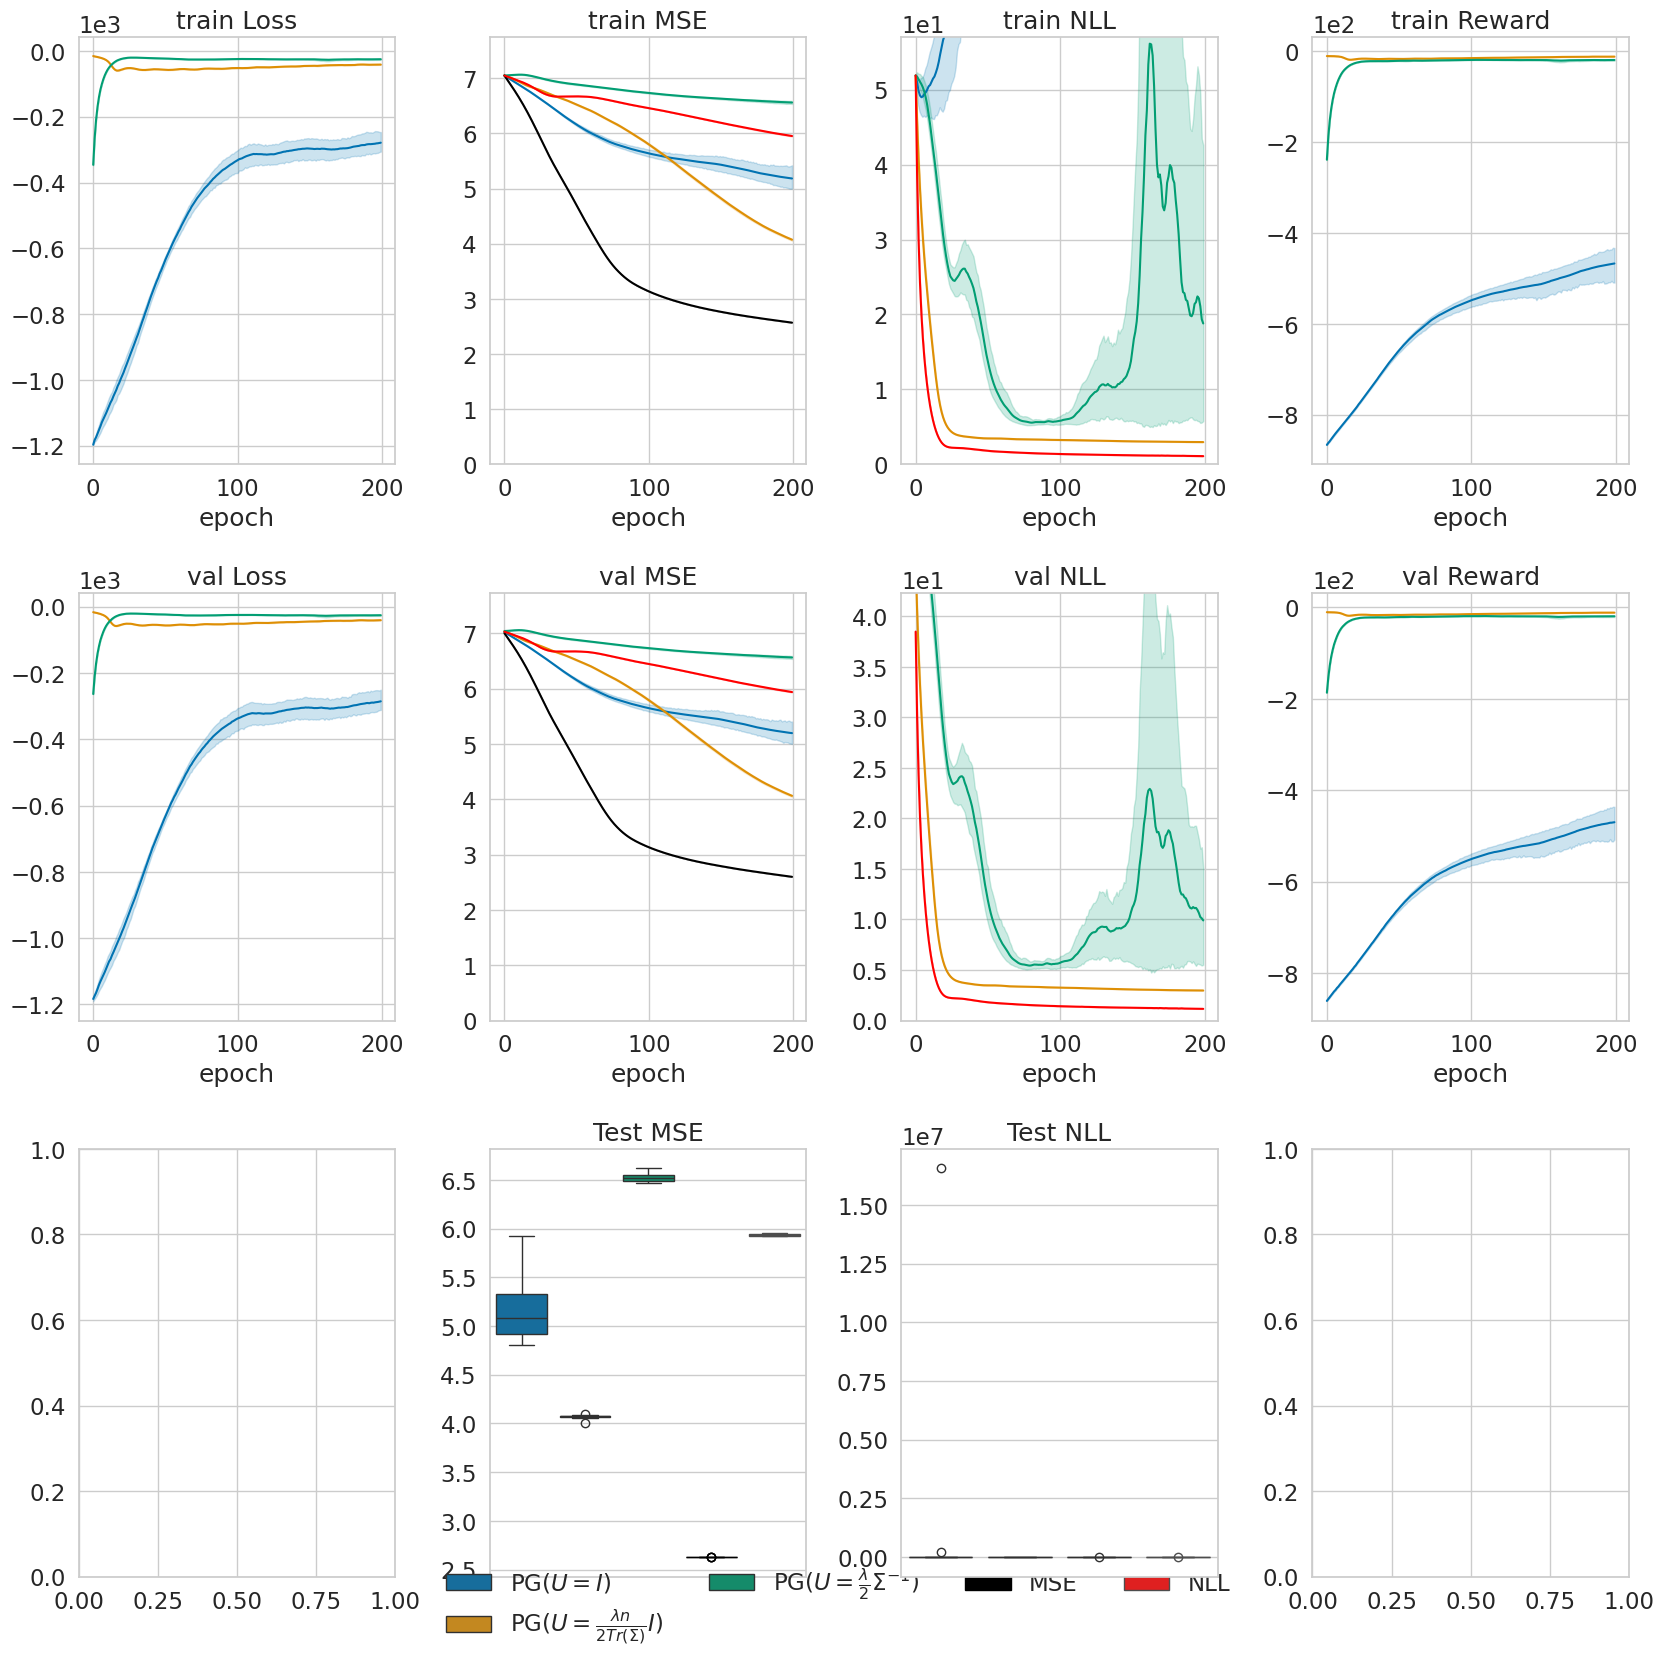

In [26]:
df = results_df.copy()
df["entropy_weight"] = df["entropy_weight"].astype("str")

metric_name = []
metric_name.append(("loss", "Loss"))
# metric_name.append(("mean_error", r"$\|\mu-\hat{\mu}_\theta\|^2$"))
metric_name.append(("mean_error", "MSE"))
# metric_name.append(("NLL", r"$\mathbb{E}_q[log\hat{p}_\theta(y|x)]$"))
metric_name.append(("NLL", "NLL"))
# metric_name.append(("std_error", r"$\|\sigma-\hat{\sigma}_\theta\|^2$"))
metric_name.append(("reward_mean", "Reward"))
# metric_name.append(("grad_norm", "Gradient norm"))

_, ax = plt.subplots(
    3, len(metric_name), figsize=(20, 20), gridspec_kw=dict(hspace=0.3, wspace=0.3)
)

# Train / Val
for tr_val_idx, train_val in enumerate(["train", "val"]):
    sub_df = df[df["train_val"] == train_val].copy()
    for i, (metric, name) in enumerate(metric_name):
        sns.lineplot(
            data=sub_df.dropna(subset=["U"]),
            x="epoch",
            y=metric,
            hue="U",  # "entropy_weight",
            # style="U",
            ax=ax[tr_val_idx, i],
            legend=False,
        )
        if metric == "mean_error":
            sns.lineplot(
                data=sub_df[sub_df["loss_type"] == "MSE"],
                x="epoch",
                y=metric,
                ax=ax[tr_val_idx, i],
                color="black",
                legend=False,
            )
        if metric not in ["reward_mean", "loss"]:
            sns.lineplot(
                data=sub_df[sub_df["loss_type"] == "NLL"],
                x="epoch",
                y=metric,
                ax=ax[tr_val_idx, i],
                color="red",
                legend=False,
            )
            max_for_lim = sub_df[(sub_df["loss_type"] == "NLL")][metric].max()
            ax[tr_val_idx, i].set_ylim(
                min(sub_df[(sub_df["loss_type"] == "NLL")][metric].min(), 0.0),
                max_for_lim + 0.1 * max_for_lim,
            )
        ax[tr_val_idx, i].set_ylabel(None)
        ax[tr_val_idx, i].set_title(f"{train_val} {name}")
        ax[tr_val_idx, i].ticklabel_format(axis="y", style="sci", scilimits=(0, 1))

# Test
sub_df = df[df["train_val"] == "test"].copy()
for i, (metric, name) in enumerate(metric_name):
    if metric in ["loss", "reward_mean"]:
        continue
    sns.boxplot(
        data=sub_df.dropna(subset=["U"]),
        x="U",
        y=metric,
        hue="U",  # "entropy_weight",
        # style="U",
        ax=ax[2, i],
        legend=False if i != 1 else True,
    )
    if metric == "mean_error":
        sns.boxplot(
            data=sub_df[sub_df["loss_type"] == "MSE"],
            x="loss_type",
            y=metric,
            ax=ax[2, i],
            color="black",
            label="MSE",
        )
    sns.boxplot(
        data=sub_df[sub_df["loss_type"] == "NLL"],
        x="loss_type",
        y=metric,
        ax=ax[2, i],
        color="red",
        label=None if i != 1 else "NLL",
    )
    # max_for_lim = sub_df[(sub_df["loss_type"] == "NLL")][metric].max()
    # ax[i].set_ylim(
    #     min(sub_df[(sub_df["loss_type"] == "NLL")][metric].min(), 0.0),
    #     max_for_lim + 0.1 * max_for_lim,
    # )
    ax[2, i].set_ylabel(None)
    ax[2, i].set_xlabel(None)
    ax[2, i].set_xticklabels([])
    ax[2, i].set_title(f"Test {name}")
    ax[2, i].ticklabel_format(axis="y", style="sci", scilimits=(0, 1))

ax[2, 1].legend(bbox_to_anchor=(1.1, -0.21), loc="lower center", ncol=4, frameon=False)
# ax[0].legend(bbox_to_anchor=(1.73, 1.03))
# plt.savefig("../figures/toy_avg.pdf", bbox_inches="tight")
plt.show()

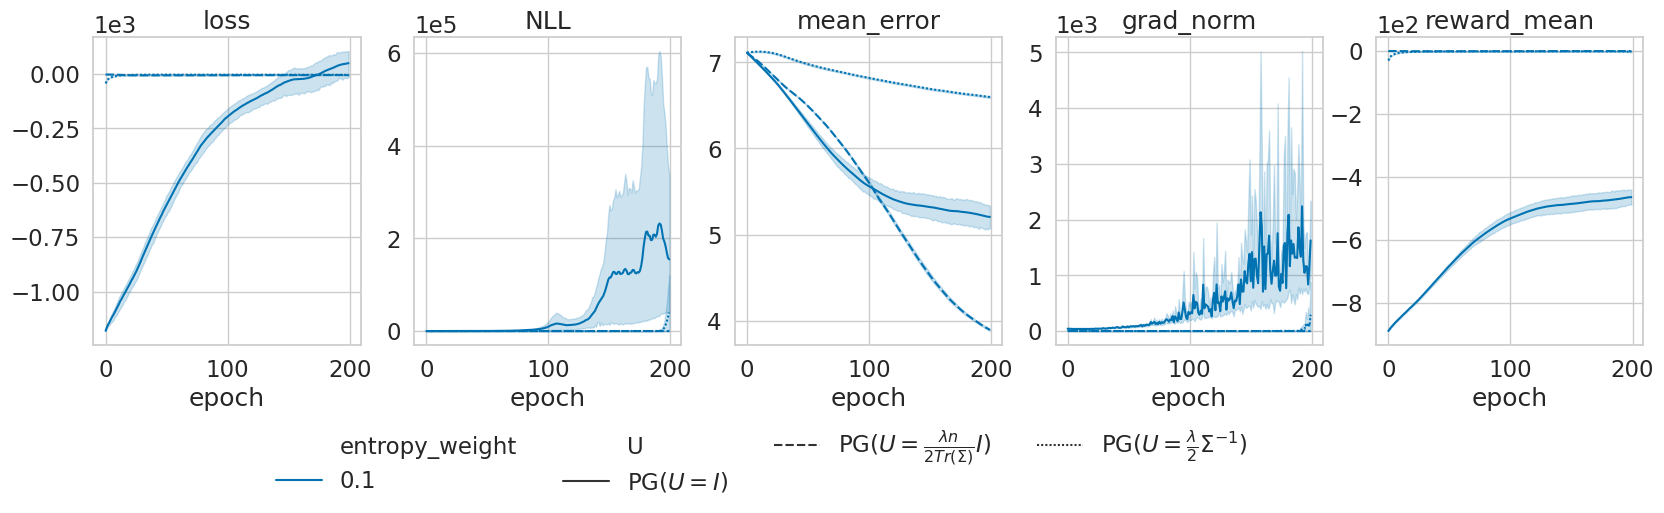

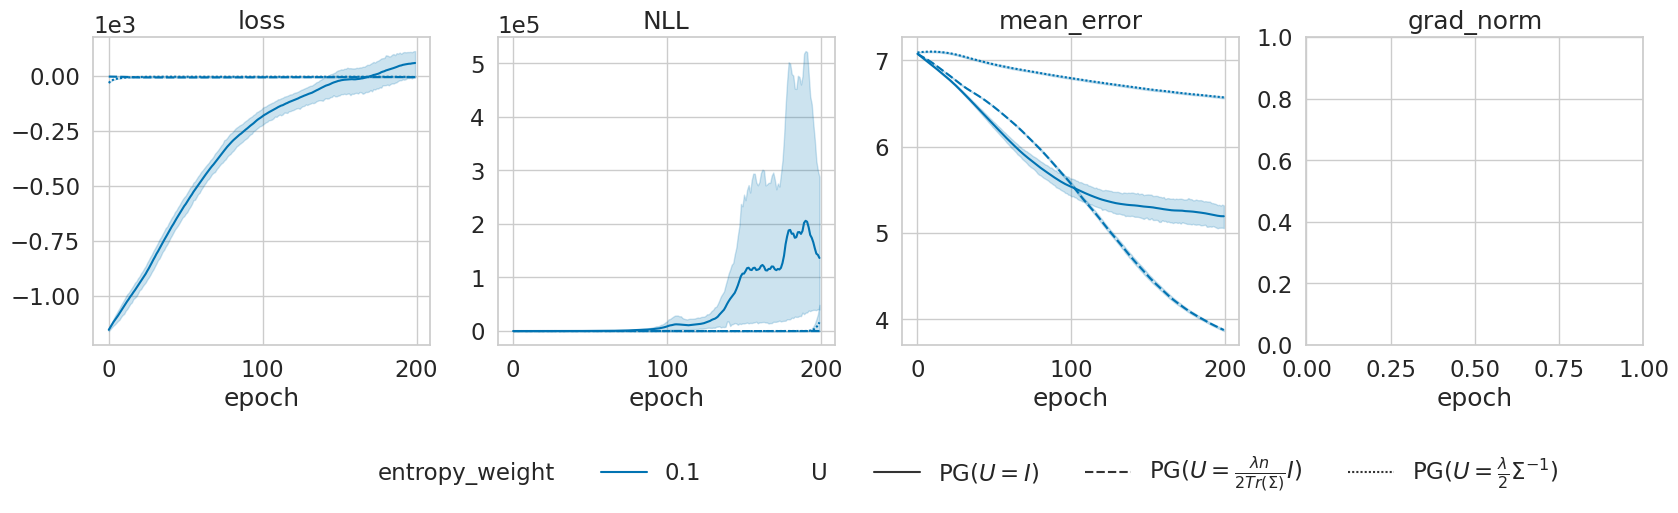

In [20]:
hue_variable = "entropy_weight"
style_variable = "U"

_, ax = plt.subplots(1, 5, figsize=(20, 4))
for i, metric in enumerate(["loss", "NLL", "mean_error", "grad_norm", "reward_mean"]):
    sns.lineplot(
        data=df[
            (df["train_val"] == "train")
            & (df["loss_type"].str.contains("PG", na=False))
        ],
        x="epoch",
        y=metric,
        hue=hue_variable,
        style=style_variable,
        ax=ax[i],
        legend=False if i > 0 else True,
    )
    ax[i].set_ylabel(None)
    ax[i].set_title(metric)
    ax[i].ticklabel_format(axis="y", style="sci", scilimits=(0, 1))
ax[0].legend(bbox_to_anchor=(2.5, -0.55), loc="lower center", ncol=4, frameon=False)

_, ax = plt.subplots(1, 4, figsize=(20, 4))
for i, metric in enumerate(["loss", "NLL", "mean_error", "grad_norm"]):
    sns.lineplot(
        data=df[
            (df["train_val"] == "val") & (df["loss_type"].str.contains("PG", na=False))
        ],
        x="epoch",
        y=metric,
        hue=hue_variable,
        style=style_variable,
        ax=ax[i],
        legend=False if i > 0 else True,
    )
    ax[i].set_ylabel(None)
    ax[i].set_title(metric)
    ax[i].ticklabel_format(axis="y", style="sci", scilimits=(0, 1))
ax[0].legend(bbox_to_anchor=(2.5, -0.55), loc="lower center", ncol=6, frameon=False)
plt.show()

In [33]:
# Separate MSE and NLL baseline results
baseline_stats = (
    test_data.groupby("loss_type")
    .agg({"mean_error": ["mean", "std", "count"], "NLL": ["mean", "std", "count"]})
    .round(4)
)
print(baseline_stats)

                                                   mean_error                \
                                                         mean     std count   
loss_type                                                                     
MSE                                                    2.6518  0.0000    10   
NLL                                                    5.9957  0.0110    10   
PG(lam=0.5)_Mahalanobis($I$)                           3.8675  0.3250    10   
PG(lam=0.5)_Mahalanobis($\frac{\lambda n}{2 Tr(...     3.7610  0.0132    10   
PG(lam=0.73)_Mahalanobis($I$)                          3.0971  0.1138    10   
PG(lam=0.73)_Mahalanobis($\frac{\lambda n}{2 Tr...     3.7576  0.0143    10   
PG(lam=1.08)_Mahalanobis($I$)                          2.9600  0.0375    10   
PG(lam=1.08)_Mahalanobis($\frac{\lambda n}{2 Tr...     3.7602  0.0076    10   
PG(lam=1.58)_Mahalanobis($I$)                          2.9136  0.0111    10   
PG(lam=1.58)_Mahalanobis($\frac{\lambda n}{2 Tr...  